In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Introduction
This is intended to explain how the NRG data produced by Yaakov Kleeorin (and Yigal Meir) is used in fitting to experimental data

# Setting up Notebook

In [2]:
# Get all the external imports out of the way
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import datetime

In [3]:
print(f'Notebook last run on {datetime.date.today()}')

Notebook last run on 2022-03-23


In [4]:
%matplotlib inline
# Adjust so that figures look OK
mpl.rcParams.update({
    'figure.figsize': (8, 4.8),
    'figure.dpi': 110,  #27in 1440p = 110
})

Next we'll import a module from my larger analysis package that contains a lot of useful functions related to NRG fitting... We'll first use it only to load the data from `.mat` files, but later will show some of the things it can do to make fitting etc easier.

In [5]:
from dat_analysis.analysis_tools import nrg  # Where all my NRG analysis functions reside

# NRG Data as provided

First let's look at the NRG data as provided

A couple of notes about the NRG data.
- All energies are defined in units of bandwidth (where bandwidth == $E_F$ = 8.5 meV for a 2DEG with electron density 2.42e15 /cm^2).
- For $T \gg T_K$ it is only the ratio $\Gamma / T$ that is important, but for low T (or high $\Gamma$) the ratio $T/T_K$ becomes important, and $T_K$ is not a simple function of $\Gamma$.

The data is in two files, `NRGResultsNew.mat` and `NRGResultsNewWide.mat`. The narrow data is best for thermally broadened data, but is not wide enough for gamma broadened data, so the gamma broadened data is contained in the wider calculations

In order to make it easier to use, I combine both datasets into one taking the best of both, and making sure they have the same data shape. The mismatch between the size of the narrow arrays and wide arrays is filled with `np.nan` in the narrow arrays.
I use a class for this so that it is easier to see what data is available

In [6]:
data = nrg.NRGData.from_mat(_use_wide=True)  # This uses both narrow and wide data, and is the default behaviour

`data` now refers to an object which holds all the data in the `.mat` files. Including `[ens, ts, conductance, dndt, entropy, occupation, int_dndt, gs]`.



In [7]:
attrs = ['ens', 'ts', 'conductance', 'dndt', 'entropy', 'occupation', 'int_dndt', 'gs']
for attr in attrs:
    arr = getattr(data, attr)
    print(f'{attr}.shape = {arr.shape}')

ens.shape = (40, 2001)
ts.shape = (40,)
conductance.shape = (40, 2001)
dndt.shape = (40, 2001)
entropy.shape = (40, 2001)
occupation.shape = (40, 2001)
int_dndt.shape = (40, 2001)
gs.shape = (40,)


The arrays `ts` and `gs` correspond to the whole 1D arrays of data, and so only have the y shape

Now let's look at the data

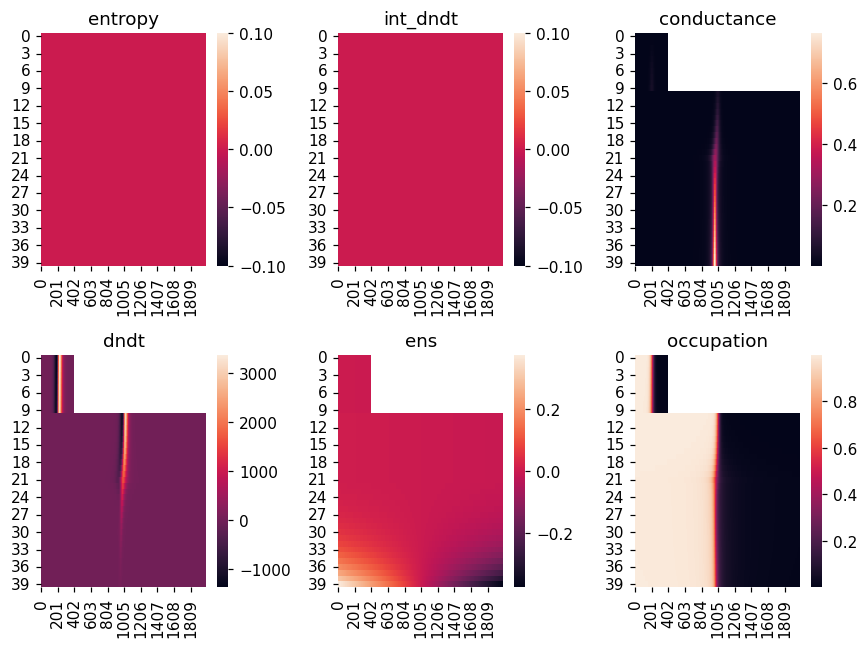

In [8]:
attrs_2d = list(set(attrs) - {'ts', 'gs'})

fig, axs = plt.subplots(2, 3, figsize=(8,6))
axs = axs.flatten()

for attr, ax in zip(attrs_2d, axs):
    ax: plt.Axes
    sns.heatmap(ax=ax, data=getattr(data, attr))
    ax.set_title(f'{attr}')

fig.tight_layout()

The mismatch in data shape can be seen here, where the rows 0-9 are from the narrow dataset and are filled with `np.nan` to match the data shape of the wider data

Note that for the new NRG data, entropy and int_dndt have **NOT** been calculated as this is a very expensive operation. However, the `dndt` data is sufficient to obtain the entropy changes given that entropy ends at Ln2 in the occupied side.

The `ens` array is the x-axis (effectively sweep gate) data for all of the other datasets

e.g.

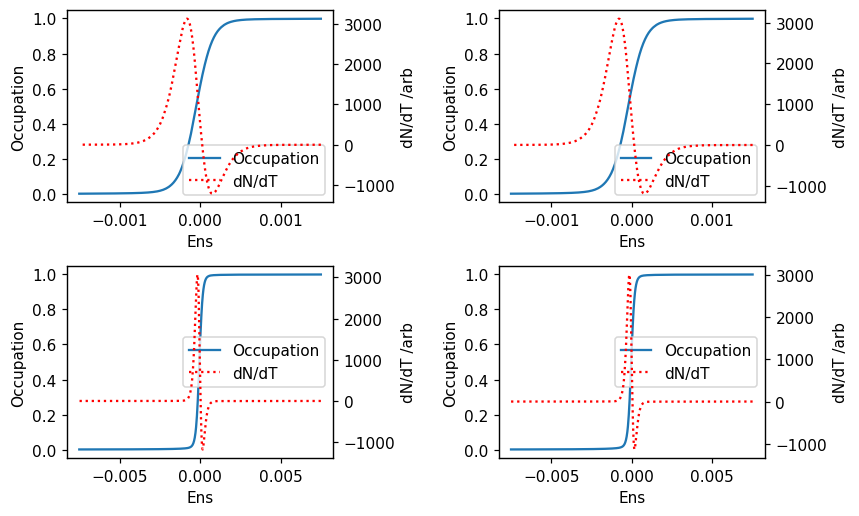

In [9]:
rows = [8, 9, 10, 11]  # rows around the change from narrow to wide datasets

fig, axs = plt.subplots(2,2)
axs = axs.flatten()

for r, ax in zip(rows, axs):
    x = data.ens[r]
    occ_data = data.occupation[r]
    dndt_data = data.dndt[r]

    ax.plot(x, occ_data, label='Occupation')
    ax.set_xlabel('Ens')
    ax.set_ylabel('Occupation')
    ax.plot([], [], 'r:', label='dN/dT')
    ax.legend()

    ax2 = ax.twinx()
    ax2.plot(x, dndt_data, 'r:')
    ax2.set_ylabel('dN/dT /arb')

fig.tight_layout()

Note that the dndt data is scaled s.t. integrating (taking into account the ens spacing) results in close to, but not exactly the expected Ln2 total entropy change (see below).

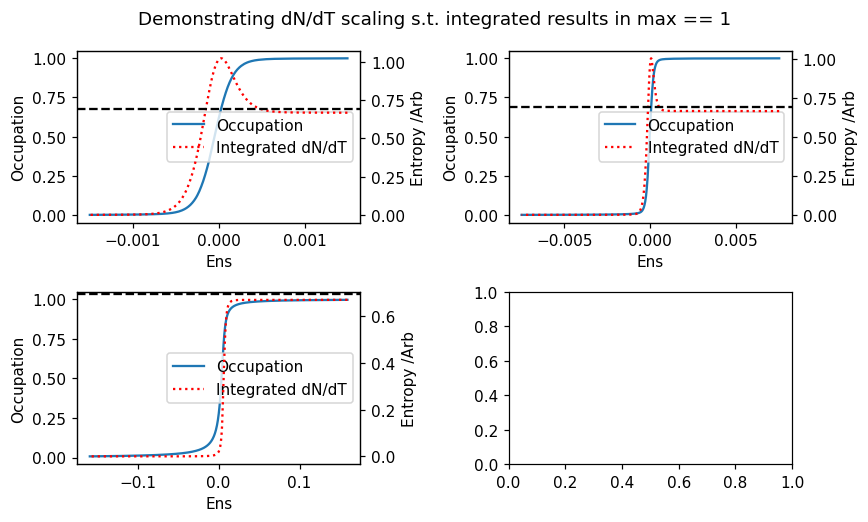

In [10]:
rows = [8, 11, 35]  

fig, axs = plt.subplots(2,2)
fig.suptitle(f'Demonstrating dN/dT scaling s.t. integrated results in max == 1')
axs = axs.flatten()

for r, ax in zip(rows, axs):
    x = data.ens[r]
    occ_data = data.occupation[r]
    dndt_data = data.dndt[r]
    int_data = np.nancumsum(dndt_data)*np.nanmean(np.diff(x))
    int_data = int_data - np.nanmin(int_data)

    ax.plot(x, occ_data, label='Occupation')
    ax.set_xlabel('Ens')
    ax.set_ylabel('Occupation')
    ax.plot([], [], 'r:', label='Integrated dN/dT')
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(x, int_data, 'r:')
    ax2.set_ylabel('Entropy /Arb')
    
    ax2.axhline(np.log(2), color='k', linestyle='--')

fig.tight_layout()

Note that the integrated entropy always ends close to but not quite Ln2. I'm not sure how the dN/dT data was scaled in the NRG simulation, but I believe it was a choice rather than a result of the model used.

We can plot the data using the `ens` and `g/t` ratios to see what the full space of calculated data really looks like

In [11]:
np.repeat((data.ts/data.gs)[:, None], data.ens.shape[-1], axis=1).shape


(40, 2001)

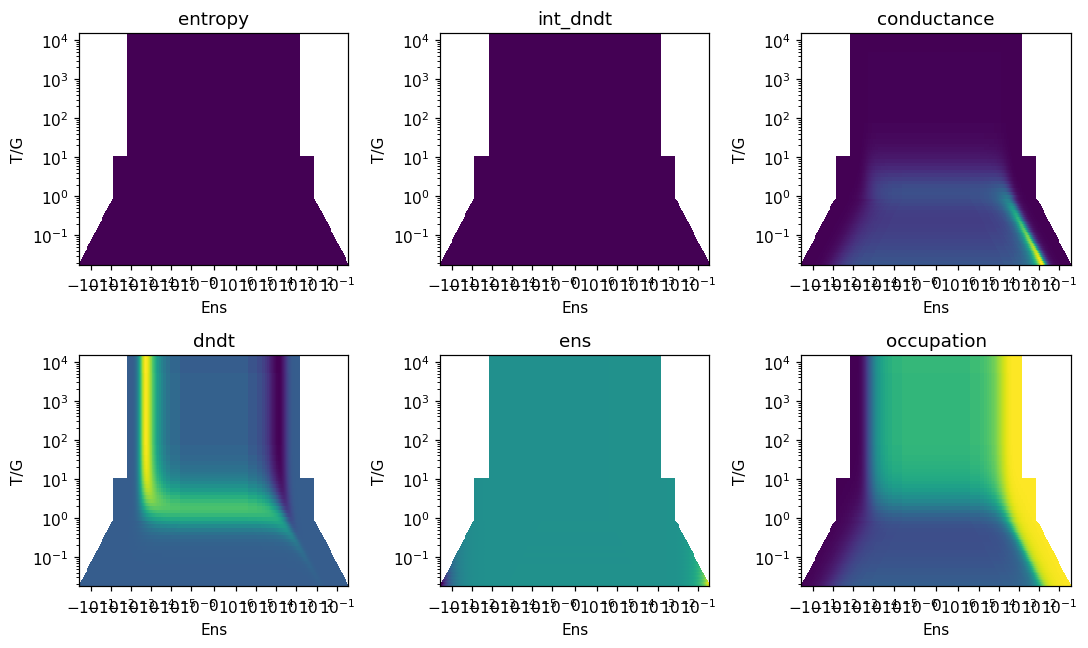

In [12]:
X = data.ens  # same shape as data2d
Y = data.ts/data.gs  # Only 1D

X1, X2 = X[0:10], X[10:]  # Narrow, Wide
# X1 = X1[:, ~np.isnan(X1).any(axis=0)]
X1 = X1[:, :401]


# Note: we want a meshgrid denoting corner points of pixels instead of centers
XXs = []
for X in X1, X2:
    x_stepsizes = np.array([np.mean(np.diff(_x)) for _x in X])
        # All step sizes should be the same (i.e. mean(diff) == diff[0])

    X = X+(x_stepsizes/2)[:,None]  # Shift coords half a step to right
    XX = np.append((X[:,0]-x_stepsizes)[:,None], X, axis=1)  # Add a row of left side values starting half a step left
    XX = np.append(XX[0][None,:], XX, axis=0)  # Add an additional row to match with Y+1 shape, not ideal but ok enough...
        # Not ideal because I should be extrapolating what the stepsize would be
    XXs.append(XX)


Y = np.concatenate(([Y[0]-(Y[1]-Y[0])/2], (Y[0:-1] + Y[1:])/2, [Y[-1]+(Y[-1]-Y[-2])/2]))
                        # start-half first step, midpoints, end+half last step
    # Y spacing is not equal, so mostly we want the midpoints between values
YYs = []
for XX in XXs:
    YY = np.repeat(Y[:,None], XX.shape[-1], axis=1)  # Convert to same x-axis shape as XXs
    YYs.append(YY)
YYs = [YYs[0][:11], YYs[1][10:]]  # Convert to same y-axis shape as XXs (note both use same middle coord (YYs[10]))

fig, axs = plt.subplots(2, 3, figsize=(10,6))
axs = axs.flatten()

for attr, ax in zip(attrs_2d, axs):
    data_ = getattr(data, attr)
    Zs = data_[0:10, :401], data_[10:]   # Only use Z part of data which matches XX

    for XX, YY, Z in zip(XXs, YYs, Zs):
        ax.pcolormesh(XX, YY, Z, vmin=np.nanmin(data_), vmax=np.nanmax(data_))
    ax.set_title(f'{attr}')
    ax.set_xlabel('Ens')
    ax.set_ylabel('T/G')
    ax.set_yscale('log')
    ax.set_xscale('symlog', linthresh=0.000001)
fig.tight_layout()

The graphs above are plotting with a **log** y-scale and **symlog** (symmetric log) x-scale


The key graphs here are the `dndt` and `occupation`, as these are the data we compare to.
`ens` highlights the symlog x-scale since the colorscale is just that of the x-values

`int_dndt` and `entropy` are not calculated in this data


# Fitting to NRG

## Parameters for Fitting

- **mid**: Position of N=0.5 occupation (only roughly N=0.5 for NRG - to get a more accurate center use `get_x_of_half_occ(...)`)
- **theta**:  Thermal broadening
- **g**:  Gamma broadening

##### Specific to dndt
- **amp**: Scaling of dndt calculations

##### Specific to i_sense
- **amp**: Charge step size
- **const**:  Average Charge Sensor current
- **lin**:  Cross capacitance of gate on Charge Sensor
- **occ_lin**:  Change in `lin` as a fn of occupation


## NRG Functions (i.e. equivalent to analytical functions)
In order to use this data for fitting routines, we require a function which can take **any** value of all fitting parameters (Gamma, Theta, En etc), so we need to interpolate between the nearest rows of data. And we might want to do this for any of the NRG datasets. From top down:

- One can get such a function from `NRG_func_generator(which='i_sense')` for a function for the specified data (e.g. `[i_sense, occupation, dndt]`)
    - i.e. This returns a function which takes all the usual fitting parameters - (x, mid, g, theta, amp, lin, const, occ_lin)
- It does so by wrapping `nrg_func(...)`; a function which takes all the regular parameters + which data is being requested
- That requests an interpolator from `_get_interpolator(...)` and then performs the interpolation with the values passed to return a value/array of answers
- `_get_interpolator(...)` takes the `theta/g` ratio, and name of data to figure out exactly which rows of data from which dataset needs to be interpolated.
    - To avoid having to rebuild the same interpolator over and over, this then calls a **cached** function `_cached_interpolator` which actually generates the interpolator. Note: `_get_interpolator(...)` cannot be cached as the call to it could have **any** value of `theta/g` even if they end up returning the same interpolator
- The `_cached_interpolator(...)` is called with an index and data name, so this has well-defined call arguments which can be cached so future calls for the same interpolator don't have to be calculated again.
    - It takes the two consecutive rows of data that will be interpolated between
    - Does a 1D interpolation of the wider of the two rows of data to match the ens axis of the narrower data (wider/narrower in ens)
    - Then creates a 2D interpolator between the two rows of data
    - Converts the 2D interpolator into a function which takes the usual arguments (minus `[g, theta]`) and additionally:
        - Adds an option for `i_sense` data by taking into account `[mid, amp, lin, const, occ_lin]`
        - Scales dndt data with `amp` to help with arbitrary scaling of dndt calculations
    - Returns the function which takes the usual arguments

A couple of demonstrations of the use of these functions to generate data, although usually they will only be used for fitting

Notice that the true x value of N=0.5 is actually x=-2.1021


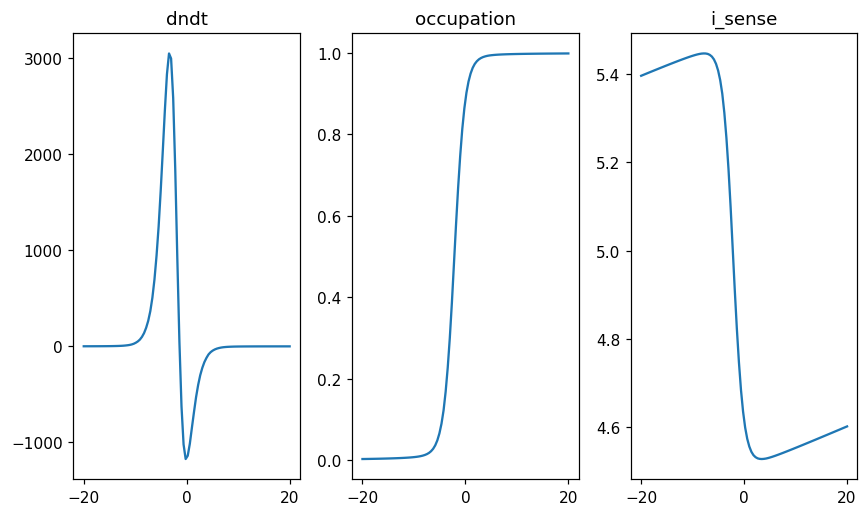

In [13]:
theta = 1
gamma = 0.1
amp = 1
mid = 0
const = 5
lin = 0.005
occ_lin = 0

x = np.linspace(-20, 20, 100)

data_names = ['dndt', 'occupation', 'i_sense']

fig, axs = plt.subplots(1, 3)
axs = axs.flatten()

for name, ax in zip(data_names, axs):
    func = nrg.NRG_func_generator(which=name)
    data = func(x=x, mid=mid, amp=amp, const=const, lin=lin, occ_lin=occ_lin, g=gamma, theta=theta)
        # Note that only x, mid, gamma, theta are used for all three datas, they are ignored for the wrong data types
    ax.plot(x, data)
    ax.set_title(f'{name}')

fig.tight_layout()
print(f'Notice that the true x value of N=0.5 is actually x={nrg.get_x_of_half_occ(theta=theta, g=gamma):.4f}')


 Although the center of transition ($N = 0.5$) is close to but not quite $x = 0$. The NRG data as provided has an absolute zero given by the ens, however, this does not align with $N = 0.5$ (which makes sense since entropy should shift the occupation with temperature etc). 
 For comparison to experimental data, it is helpful to have the center of transition be close to $x = 0$ for ease of fitting (it is difficult to estimate a center value otherwise). This is achieved by shifting the x-axis of NRG data **AFTER** interpolation with the line:
 $$
 x_{\text{shifted}} = x - x_0 - \Gamma \times (-2.2) - \Theta \times(-1.5)
 $$
 where the factors $-2.2$ and $-1.5$ were found through trial and error to result in the $N=0.5$ being close to $x=0$
 
 And then scaling to account for thermal broadening (which should be OK, assuming that data is dependent on G/T ratio only) using:
 $$
 x_{\text{scaled}} = x_{\text{shifted}} \times \frac{0.0001}{\Theta}
 $$
 where $0.0001$ is the Theta value used in the NRG calculations

Or we can plot 2D using the generated function

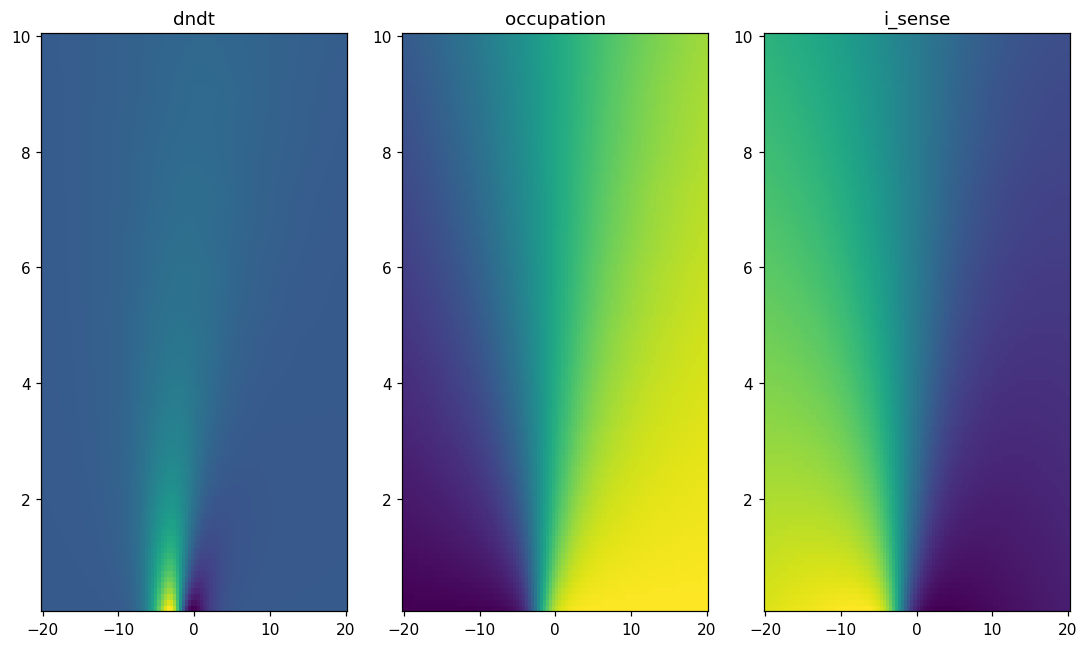

In [14]:
from dat_analysis.plotting.mpl.util import xy_to_meshgrid  # Just to help with plotting 2D data
x = np.linspace(-20, 20, 100)
g_over_t = np.linspace(0.1, 10, 100)
theta = 1


gamma = g_over_t * theta

fig, axs = plt.subplots(1, 3, figsize=(10, 6))
axs = axs.flatten()

for name, ax in zip(data_names, axs):
    func = nrg.NRG_func_generator(which=name)
    data = np.array([func(x=x, mid=mid, amp=amp, const=const, lin=lin, occ_lin=occ_lin, g=g, theta=theta) for g in gamma])
    xx, yy = xy_to_meshgrid(x, g_over_t)
    ax.pcolormesh(xx, yy, data)
    ax.set_title(f'{name}')

fig.tight_layout()




I use the `lmfit` python package for fitting. We'll import that here for some examples, but later I will show how NRG fitting can be done directly using my `dat_analysis.analysis_tools.nrg` module.

In [15]:
import lmfit as lm

As an example, I will generate some fake `i_sense` data using the function demonstrated above

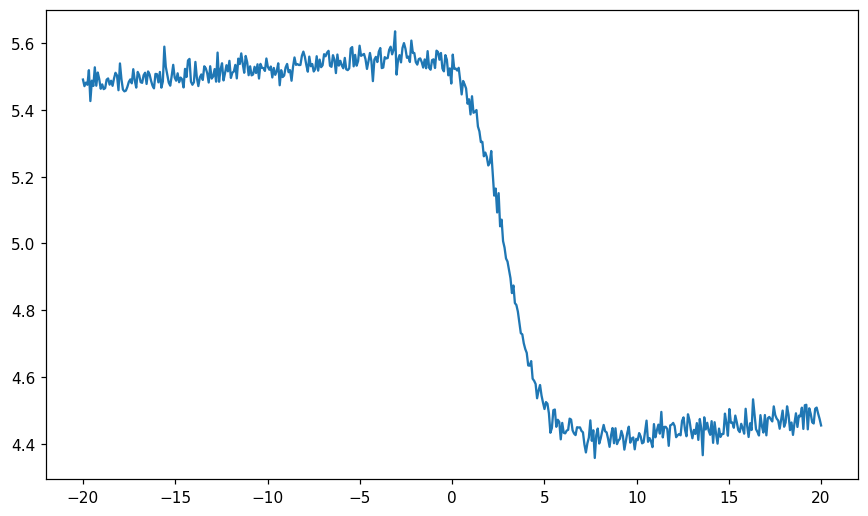

In [16]:
theta = 1
gamma = 0.005  # Very weakly coupled to start with
amp = 1.2
mid = 5
const = 5
lin = 0.005
occ_lin = 0

noise_fraction = 0.02

x = np.linspace(-20, 20, 500)

i_sense_func = nrg.NRG_func_generator(which='i_sense')
fake_data = i_sense_func(x=x, mid=mid, const=const, amp=amp, lin=lin, g=gamma, theta=theta, occ_lin=occ_lin)
fake_data += np.random.normal(0, amp*noise_fraction, x.shape[0])

fig, ax = plt.subplots()
ax.plot(x, fake_data)
fig.tight_layout()

Using the data above to demonstrate fitting to NRG

In [17]:
params = lm.Parameters()
params.add_many(
    #            name, value, vary, min, max
    lm.Parameter('mid', np.nanmean(x), True, -100, 100),  # Guess middle of dataset
    lm.Parameter('amp', np.nanmax(data)-np.nanmin(data), True, 0),  # Guess similar to amplitude of total data
    lm.Parameter('lin', 0, True, 0, 0.1),  # Generally requires quite strict limits
    lm.Parameter('const', np.nanmean(data), True),  # Roughly in middle of data
    lm.Parameter('theta', 5, True, 0, 20),  # Usually 5 works quite well, could do something more fancy if needed
    lm.Parameter('g', 0.001, False),  # Holding fixed near zero because fitting weakly coupled data
    lm.Parameter('occ_lin', 0, False),  # Usually not needed
)

Note that the parameter `g` cannot be set exactly to zero and is **NOT** allowed to vary here (since we are trying to fit weakly coupled data).
In fact, even with `g` set 5x lower than the generated data, we should get a good fit since we are in the weakly coupled regime.
Also not allowing `occ_lin` to vary just because that is not often needed

In [18]:
func = nrg.NRG_func_generator(which='i_sense')

model = lm.model.Model(func)
fit = model.fit(fake_data, x=x, params=params, method='powell', nan_policy='omit')

C:\Users\Child\.conda\envs\DatAnalysis\lib\site-packages\lmfit\minimizer.py:850: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\Child\.conda\envs\DatAnalysis\lib\site-packages\lmfit\minimizer.py:857: RuntimeWarning:

invalid value encountered in sqrt



Note: The fitting method has been specified as `powell` rather than the default `leastsq`.

I experimented with many other fitting modes and found `powell` to be most reliable. I believe this is because of the discontinuous gradient of the interpolated data (i.e. corners at each calculated value)

In [19]:
print('Comparison of Expected vs Fit values\nName\t\tExpected\t\tFit')
for expected, name in zip([mid, amp, const, lin, theta, gamma, occ_lin], ['mid', 'amp', 'const', 'lin', 'theta', 'g', 'occ_lin']):
    par = fit.params.get(name)
    print(f'{name:10}\t\t{expected:.1f}\t\t{par.value:.2f}\u00b1{par.stderr:.2f}')



Comparison of Expected vs Fit values
Name		Expected		Fit
mid       		5.0		5.03±nan
amp       		1.2		1.20±nan
const     		5.0		5.00±nan
lin       		0.0		0.01±nan
theta     		1.0		1.01±nan
g         		0.0		0.00±0.00
occ_lin   		0.0		0.00±0.00


Or we can look at the full fit report

fit

And now lets plot the fit on the data

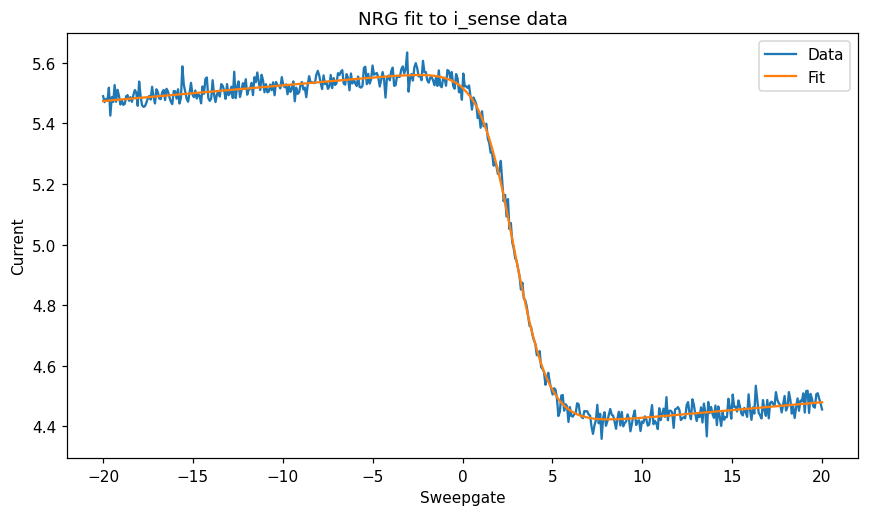

In [20]:
fig, ax = plt.subplots(1)
ax.plot(x, fake_data, label='Data')
ax.plot(x, fit.eval(x=x), label='Fit')
ax.set_title(f'NRG fit to i_sense data')
ax.set_xlabel('Sweepgate')
ax.set_ylabel('Current')
ax.legend()
fig.tight_layout()

Because both g and theta are so strongly correlated, for fitting strongly coupled data (g > theta), it is necessary to hold theta fixed at the expected value.

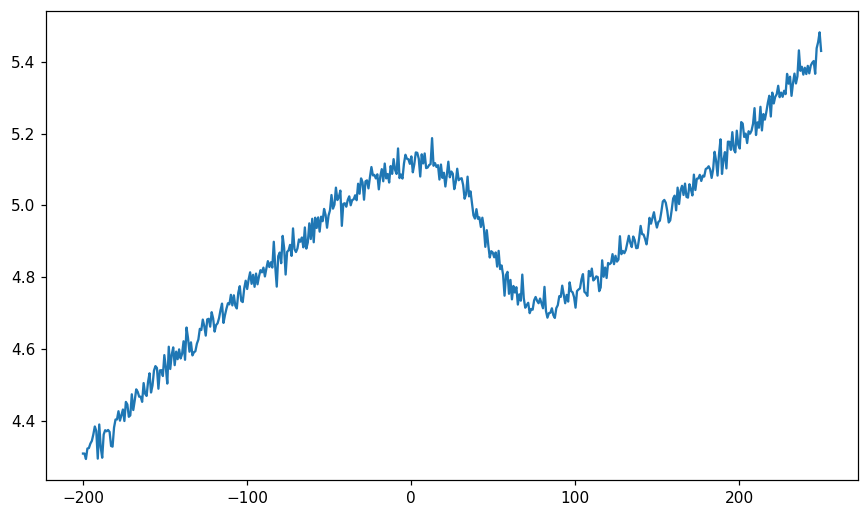

In [21]:
theta = 1
gamma = 15  # Made Gamma >> T
amp = 1.2
mid = 50
const = 5
lin = 0.005
occ_lin = 0

noise_fraction = 0.02

x = np.linspace(-200, 250, 500)  # Much wider x-axis

i_sense_func = nrg.NRG_func_generator(which='i_sense')
fake_data = i_sense_func(x=x, mid=mid, const=const, amp=amp, lin=lin, g=gamma, theta=theta, occ_lin=occ_lin)
fake_data += np.random.normal(0, amp*noise_fraction, x.shape[0])

fig, ax = plt.subplots()
ax.plot(x, fake_data)
fig.tight_layout()

Where the max/min points of the data are not near the transition sometimes causes issues with guessing amp as the max - min, but probably it is OK with this.

In [22]:
params = lm.Parameters()
params.add_many(
    #            name, value, vary, min, max
    lm.Parameter('mid', np.nanmean(x), True, -100, 100),  # Guess middle of dataset
    lm.Parameter('amp', np.nanmax(data)-np.nanmin(data), True, 0),  # Guess similar to amplitude of total data
    lm.Parameter('lin', 0, True, 0, 0.1),  # Generally requires quite strict limits
    lm.Parameter('const', np.nanmean(data), True),  # Roughly in middle of data
    lm.Parameter('theta', theta, False, 0, 20),  # Fixed theta at expected value
    lm.Parameter('g', 5, True, theta/1000, theta*50),  # Allowing to vary now, requires limits
    lm.Parameter('occ_lin', 0, False),  # Usually not needed
)

# Using same model as previously
fit = model.fit(fake_data, x=x, params=params, method='powell', nan_policy='omit')


Comparison of Expected vs Fit values
Name		Expected		Fit
mid       		 50.0		49.07±0.31
amp       		  1.2		1.17±0.02
const     		  5.0		5.00±0.00
lin       		  0.0		0.00±0.00
theta     		  1.0		1.00±0.00
g         		 15.0		14.43±0.35
occ_lin   		  0.0		0.00±0.00


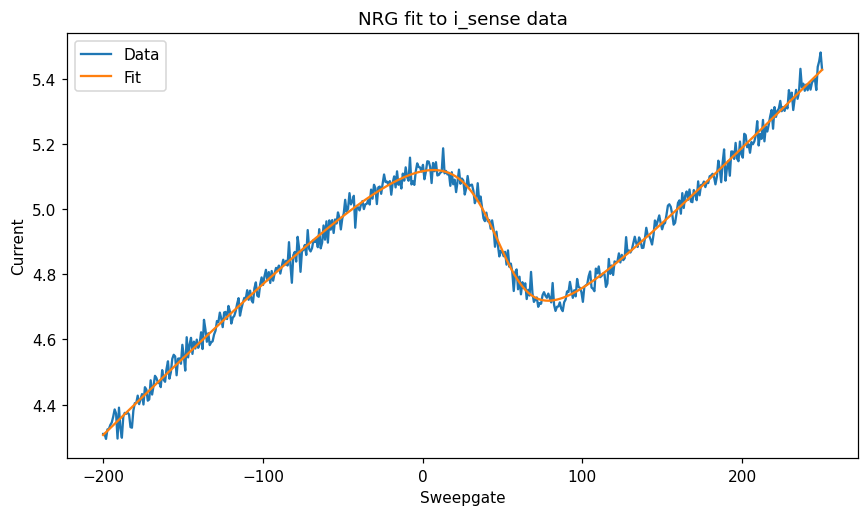

In [23]:

print('Comparison of Expected vs Fit values\nName\t\tExpected\t\tFit')
for expected, name in zip([mid, amp, const, lin, theta, gamma, occ_lin], ['mid', 'amp', 'const', 'lin', 'theta', 'g', 'occ_lin']):
    par = fit.params.get(name)
    print(f'{name:10}\t\t{expected:5.1f}\t\t{par.value:.2f}\u00b1{par.stderr:.2f}')

fig, ax = plt.subplots(1)
ax.plot(x, fake_data, label='Data')
ax.plot(x, fit.eval(x=x), label='Fit')
ax.set_title(f'NRG fit to i_sense data')
ax.set_xlabel('Sweepgate')
ax.set_ylabel('Current')
ax.legend()
fig.tight_layout()

As expected, a good fit to fake_data

### Some helpful functions for analysis

To avoid having to write so much about parameters, fit functions, etc. And to avoid having to remember silly things like always casting data to `np.float32` before fitting with lmfit, or binning datasets with millions of datapoints down to something more reasonable, there are some helpful functions in the `dat_analysis.analysis_tools.nrg` module.

Additionally, I will use this to demonstrate fitting dN/dT data

In [24]:
nrg_helper = nrg.NrgUtil()

First, let's use this to generate some fake dN/dT data

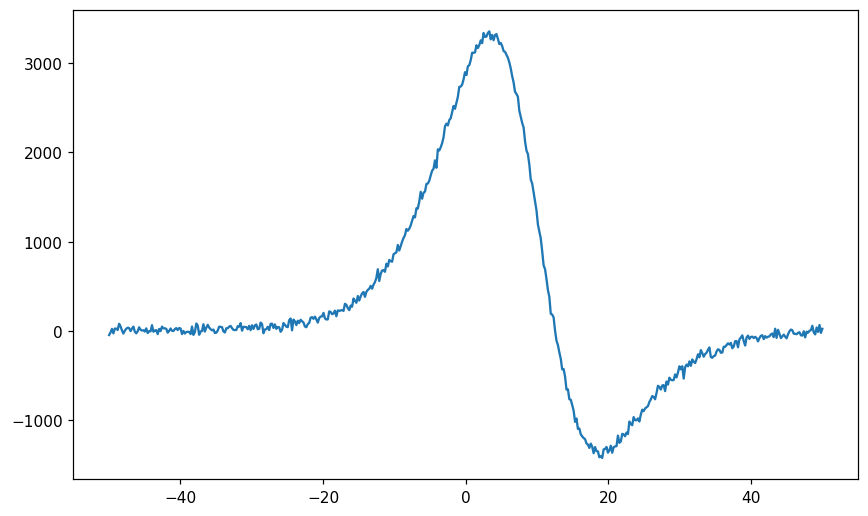

In [25]:
x = np.linspace(-50, 50, 500)
noise_ratio = 0.01

mid, amp, theta, gamma, const = 20, 1, 5, 0.05, 0
nrg_helper.init_params(mid=mid, amp=amp, theta=theta, g=gamma)
fake_data = nrg_helper.data_from_params(x=x, which_data='dndt', which_x='sweepgate')  # Note: This returns both the data and x
    # Where x can be returned as 'sweepgate' or 'occupation'
fake_data.data += np.random.normal(0, np.nanmax(fake_data.data)*noise_ratio, fake_data.x.shape[0])  # Add noise

fig, ax = plt.subplots(1)
ax.plot(fake_data.x, fake_data.data)
fig.tight_layout()

Now let's fit the data. We'll change the initial params first so that we aren't cheating too much

In [26]:
nrg_helper.init_params(mid=0, amp=3, theta=1, g=0.001)

fit = nrg_helper.get_fit(x=fake_data.x, data=fake_data.data, which_data='dndt', vary_gamma=False, vary_theta=True)
fit

[[Model]]
    Model(nrg_func)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 347
    # data points      = 500
    # variables        = 3
    chi-square         = 572961.630
    reduced chi-square = 1152.84030
    Akaike info crit   = 3527.98297
    Bayesian info crit = 3540.62679
[[Variables]]
    mid:      20.0407841 +/- 0.01920859 (0.10%) (init = 0)
    theta:    5.02249834 +/- 0.00688448 (0.14%) (init = 1)
    g:        0.001 (fixed)
    amp:      0.99189938 +/- 0.00144764 (0.15%) (init = 3)
    lin:      0 (fixed)
    occ_lin:  0 (fixed)
    const:    0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(mid, theta) =  0.865
    C(theta, amp) = -0.471
    C(mid, amp)   = -0.410

Note that the `fit` returned here is my own class which contains the `lm.models.ModelResult` under `fit.fit_result`.
Mostly that isn't necessary since it is set up in a similar way. The main reason is just for storing or loading from `hdf5` files (which is not supported with the lmfit result directly).

Comparison of Expected vs Fit values
Name		Expected		Fit
mid       		 20.0		20.04±0.02
amp       		  1.0		0.99±0.00
const     		  0.0		0.00±0.00
lin       		  0.0		0.00±0.00
theta     		  5.0		5.02±0.01
g         		  0.1		0.00±0.00
occ_lin   		  0.0		0.00±0.00


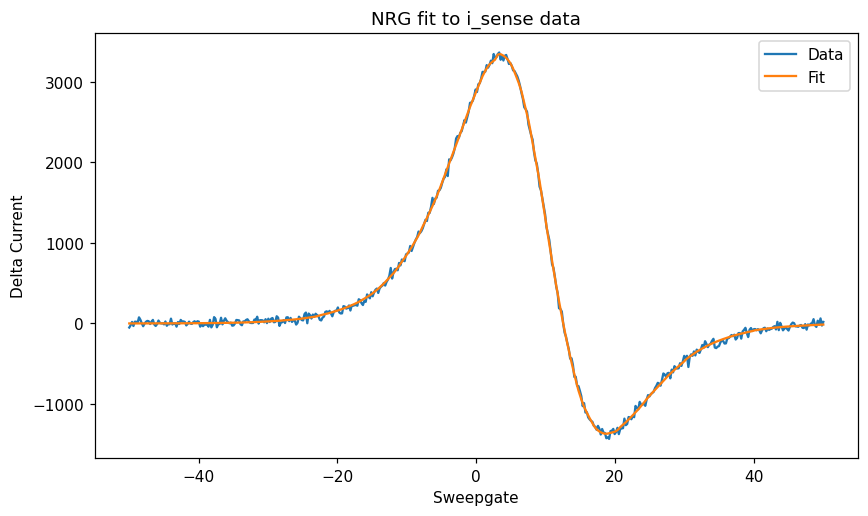

In [27]:
print('Comparison of Expected vs Fit values\nName\t\tExpected\t\tFit')
for expected, name in zip([mid, amp, const, lin, theta, gamma, occ_lin], ['mid', 'amp', 'const', 'lin', 'theta', 'g', 'occ_lin']):
    par = fit.params.get(name)
    print(f'{name:10}\t\t{expected:5.1f}\t\t{par.value:.2f}\u00b1{par.stderr:.2f}')

fig, ax = plt.subplots(1)
ax.plot(fake_data.x, fake_data.data, label='Data')
ax.plot(fake_data.x, fit.eval_fit(x=fake_data.x), label='Fit')
ax.set_title(f'NRG fit to i_sense data')
ax.set_xlabel('Sweepgate')
ax.set_ylabel('Delta Current')
ax.legend()
fig.tight_layout()

Again we see a good fit. Note that there are several fitting parameters shown above that are not used and are just held fixed.

### Plotting vs Occupation
Instead of plotting an energy/sweepgate values on the x-axis, let's plot against occupation instead. This will be useful for comparing measurements at varying G/T ratios

This is achieved by using the same parameters (specifically the `g`, `theta`, and `mid`) values to generate the expected Occupation data.
We'll just skip to using the useful functions to do this.

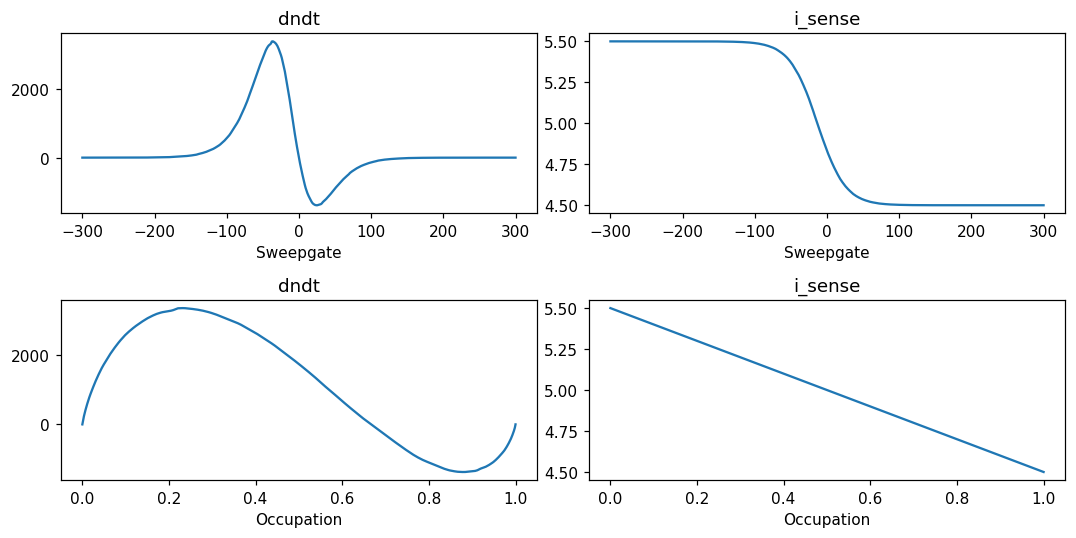

In [28]:
nrg_helper.init_params(mid=30, amp=1, theta=20, g=0.001, lin=0.000, const=5, occ_lin=0)
x = np.linspace(-300, 300, 1000)


data_names = ['dndt', 'i_sense']
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()

for name, ax in zip(data_names, axs[:2]):
    data = nrg_helper.data_from_params(x=x, which_data=name, which_x='sweepgate')
    ax.plot(data.x, data.data)
    ax.set_title(name)
    ax.set_xlabel('Sweepgate')

for name, ax in zip(data_names, axs[2:]):
    data = nrg_helper.data_from_params(x=x, which_data=name, which_x='occupation')
    ax.plot(data.x, data.data)
    ax.set_title(name)
    ax.set_xlabel('Occupation')

fig.tight_layout()

As expected, the `i_sense` data is linear when plotted against Occupation. For real data where there would also be a non-zero linear term, this would result in vertical lines at either end (i.e. changing current with no change of occupation).

Plotting dNdT this way makes it much easier to compare dN/dT for varying G/T
e.g.

Ratios to plot:  ['0.1', '0.188', '0.355', '0.669', '1.26', '2.38', '4.48', '8.45', '15.9', '30']


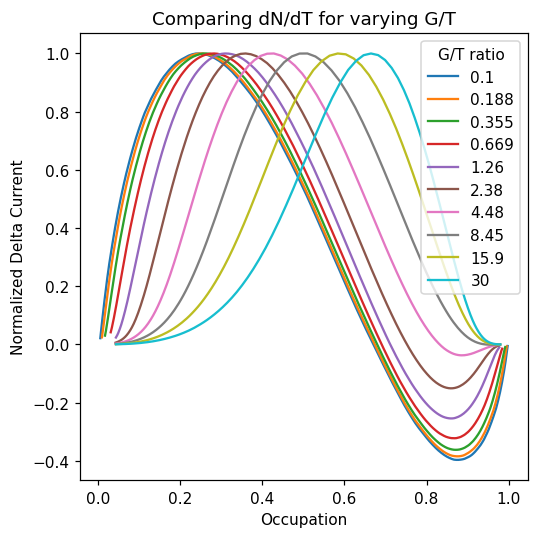

In [29]:
g_over_ts = np.logspace(np.log10(0.1), np.log10(30), 10)
theta = 10
print('Ratios to plot: ', [f'{gt:.3g}' for gt in g_over_ts])

fig, ax = plt.subplots(1, figsize=(5,5))

for gt in g_over_ts:
    nrg_helper.initial_params.gamma = gt*theta
    x = np.linspace(-max([theta, gt*theta])*15, max([theta, gt*theta])*15, 300)  # Wider x needed for wider data
    data = nrg_helper.data_from_params(x=x, which_data='dndt', which_x='occupation')
    data.data = data.data/np.nanmax(data.data)

    ax.plot(data.x, data.data, label=f'{gt:.3g}')

ax.legend(title='G/T ratio')
ax.set_title(f'Comparing dN/dT for varying G/T')
ax.set_xlabel('Occupation')
ax.set_ylabel('Normalized Delta Current')

fig.tight_layout()
